Instead of using `python-constraint`, we want to use Googles OR-Tools to solve this problem.
This is because it features [better performance and scalability](https://github.com/google/or-tools/blob/stable/ortools/sat/docs/troubleshooting.md#improving-performance-with-multiple-workers) for larger problems (mutli threaded optimizations).

In [103]:
from csv import DictReader


def load_data_from_csv(filepath):
    """Load data from CSV file"""
    courses = {}

    with open(filepath, 'r', encoding='utf-8') as file:
        reader = DictReader(file, delimiter=';')

        for row in reader:
            course = row['Studiengang']
            courses[course] = {
                'num_groups': int(row['Projektgruppen']),
                'num_committees': int(row['Kommissionen']),
                'groups': [f'{course[:3]}-G{i + 1}' for i in range(int(row['Projektgruppen']))],
                'committees': [f'{course[:3]}-C{i + 1}' for i in range(int(row['Kommissionen']))],
            }

    return courses

Define all static variables from the assignment description
These should be immutable, but since there is no easy way to enforce this in Python we add the Final "type" so IDE warns us when trying to alter the variables



In [104]:
from typing import Final

# Constraint Values
num_presentations_per_group: Final = 3
num_max_commitee_room_changes_per_day: Final = 2

# Mappings
all_rooms: Final = ["L1", "L2", "L3"]
all_time_slots: Final = ["8-9", "10-11", "13-14", "15-16"]
all_days: Final = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]
all_presentations: Final = range(num_presentations_per_group)

# Counts
num_rooms: Final = len(all_rooms)
num_slots: Final = len(all_time_slots)
num_days: Final = len(all_days)
num_max_presentations: Final = num_days * num_slots * num_rooms

# Will be filled from dataset
all_courses = {}
num_courses = 0
num_groups = {}
num_committees = {}

# Load dataset from CSV and process
data = load_data_from_csv("DS_CSP_1/pr_conf_001.csv")
num_courses = len(data)
all_courses = list(data.keys())
for key, course in data.items():
    num_groups[key] = course['num_groups']
    num_committees[key] = course['num_committees']


#### Creating variables

In [105]:
from ortools.sat.python import cp_model

model = cp_model.CpModel()
presentations = {}
committee_assigned = {}

# This array defines assignments for presentations to groups of a course.
# presentations[(c, g, d, t, r)] equals 1 if room r is assigned to slot t on day d for group g in course c
for c in all_courses:
    for g in range(num_groups[c]):
        for d in all_days:
            for t in all_time_slots:
                for r in all_rooms:
                    presentations[(c, g, d, t, r)] = model.NewBoolVar(f'p({c},{g},{d},{t},{r})')

# This array defines
for c in all_courses:
    for cm in range(num_committees[c]):
        for d in all_days:
            for t in all_time_slots:
                for r in all_rooms:
                    committee_assigned[(c, cm, d, t, r)] = model.NewBoolVar(f'cm({c},{cm},{d},{t},{r})')

print(f'Created {len(presentations)} presentation assignments.')
print(f'Created {len(committee_assigned)} committee assignments.')

Created 1200 presentation assignments.
Created 660 committee assignments.


#### Adding constraints

In [106]:
# Each course can only have one presentation a day
for c in all_courses:
    for g in range(num_groups[c]):
        for d in all_days:
            model.add_at_most_one(
                presentations[(c, g, d, t, r)]
                for t in all_time_slots
                for r in all_rooms
            )

# Each group needs to present exactly num_presentations_per_group times (3).
for c in all_courses:
    for g in range(num_groups[c]):
        presentations_given = []
        for d in all_days:
            for t in all_time_slots:
                for r in all_rooms:
                    presentations_given.append(presentations[(c, g, d, t, r)])
        model.add(sum(presentations_given) == num_presentations_per_group)

# Make sure each room can host only 1 presentation per time slot
for d in all_days:
    for t in all_time_slots:
        for r in all_rooms:
            model.add_at_most_one(
                presentations[(c, g, d, t, r)]
                for c in all_courses
                for g in range(num_groups[c])
            )

# Each committee can only be assigned to one room at a time
for c in all_courses:
    for cm in range(num_committees[c]):
        for d in all_days:
            for t in all_time_slots:
                model.AddAtMostOne(
                    committee_assigned[(c, cm, d, t, r)]
                    for r in all_rooms
                )

# Each presentation needs exactly 1 committee from the right course to be present
for c in all_courses:
    for d in all_days:
        for t in all_time_slots:
            for r in all_rooms:
                # If any group from course c presents at (d,t,r)
                groups_presenting = sum(presentations[(c, g, d, t, r)] for g in range(num_groups[c]))

                # Exactly one committee instance from course c must be there
                committees_present = sum(
                    committee_assigned[(c, cm, d, t, r)]
                    for cm in range(num_committees[c])
                )

                model.Add(groups_presenting == committees_present)


In [107]:
# Calculate if problem is feasible
total_presentations_needed = sum(num_groups[c] * num_presentations_per_group for c in all_courses)
total_slots_available = num_days * num_slots * num_rooms

print(f"Total presentations needed: {total_presentations_needed}")
print(f"Total slots available: {total_slots_available}")

solver = cp_model.CpSolver()
status = solver.solve(model)

Total presentations needed: 60
Total slots available: 60


Solution found!


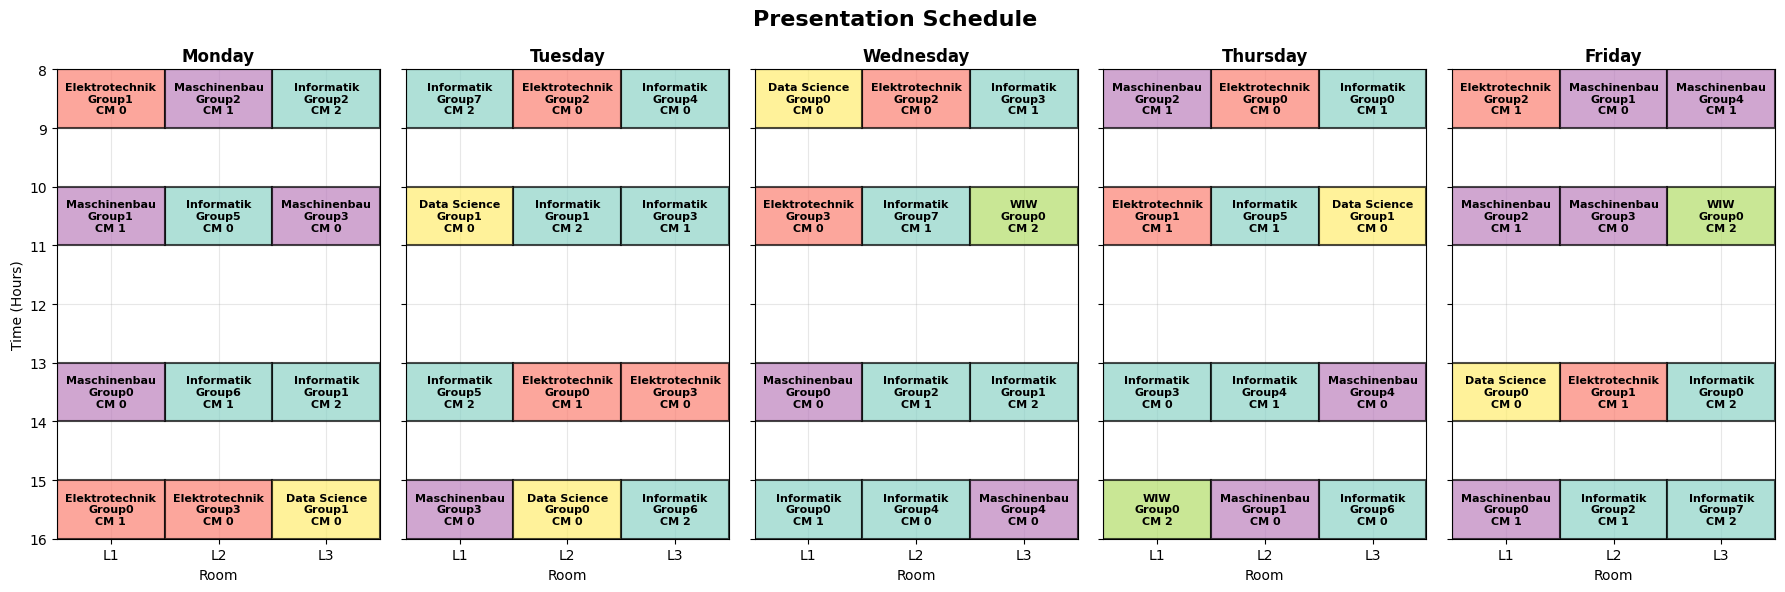

In [108]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import numpy as np

def display_timetable_ortools(solver, presentations, committee_assigned, all_courses, all_days, all_time_slots, all_rooms, num_groups, num_committees):
    """Display the OR-Tools solution as a matplotlib plot"""

    # Convert OR-Tools solution to the format your function expects
    solution_data = []

    for c in all_courses:
        for g in range(num_groups[c]):
            for d in all_days:
                for t in all_time_slots:
                    for r in all_rooms:
                        if solver.value(presentations[(c, g, d, t, r)]) == 1:
                            # Find which committee is assigned
                            committee_idx = None
                            for cm in range(num_committees[c]):
                                if solver.value(committee_assigned[(c, cm, d, t, r)]) == 1:
                                    committee_idx = cm
                                    break

                            solution_data.append({
                                'course': c,
                                'group': g,
                                'committee': committee_idx,
                                'day': d,
                                'time_slot': t,
                                'room': r
                            })

    # Create figure
    fig, axes = plt.subplots(1, len(all_days), figsize=(18, 6), sharey=True)
    fig.suptitle('Presentation Schedule', fontsize=16, fontweight='bold')

    # Color map for different courses
    colors = plt.cm.Set3(np.linspace(0, 1, len(all_courses)))
    course_colors = {course: colors[i] for i, course in enumerate(all_courses)}

    for day_idx, day in enumerate(all_days):
        ax = axes[day_idx]
        ax.set_title(day, fontweight='bold')
        ax.set_xlim(0, len(all_rooms))
        ax.set_ylim(8, 16)
        ax.set_xticks(np.arange(len(all_rooms)) + 0.5)
        ax.set_xticklabels(all_rooms)
        ax.set_xlabel('Room')

        if day_idx == 0:
            ax.set_yticks(range(8, 17))
            ax.set_ylabel('Time (Hours)')

        ax.grid(True, alpha=0.3)
        ax.set_axisbelow(True)
        ax.invert_yaxis()

        # Plot presentations for this day
        for pres in solution_data:
            if pres['day'] == day:
                room_idx = all_rooms.index(pres['room'])

                # Parse time slot to get start and end hour
                start_hour, end_hour = map(int, pres['time_slot'].split('-'))

                course = pres['course']
                group = pres['group']
                committee_idx = pres['committee']

                color = course_colors[course]

                # Draw rectangle
                rect = Rectangle((room_idx, start_hour), 1, end_hour - start_hour,
                                 linewidth=1.5, edgecolor='black',
                                 facecolor=color, alpha=0.7)
                ax.add_patch(rect)

                # Add text in the center
                text = f"{course}\nGroup{group}\nCM {committee_idx}"
                ax.text(room_idx + 0.5, (start_hour + end_hour) / 2, text,
                        ha='center', va='center', fontsize=8, fontweight='bold')

    plt.tight_layout()
    plt.show()


if status == cp_model.OPTIMAL or status == cp_model.FEASIBLE:
    print("Solution found!")
    display_timetable_ortools(
        solver,
        presentations,
        committee_assigned,
        all_courses,
        all_days,
        all_time_slots,
        all_rooms,
        num_groups,
        num_committees
    )
else:
    print("No solution found!")